In [1]:
from cobra.io import read_sbml_model
from utils.flux_coupling import add_ratio_constraint_cobra

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

## Constraining the individual models:

NJ4:  
constrained to solventogenesis state

In [2]:
# restrict reaction reversibility

reactions = ["ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", 
             "ADCi", "PTAr", "POR_syn", "FNOR", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f",] #ABE pathway

KO_rx = ["XYLANabc", "GLCURS1"] #xylan uptake reactions

for rx in reactions:
    nj4.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4.reactions.get_by_id(rx).bounds = (-1000, 0)

for rx in KO_rx:
    nj4.reactions.get_by_id(rx).bounds = (0, 0)

# TCA cycle
#nj4_acido.reactions.SUCD2.bounds = (-1000, 1000) #only relevant if doing 3-step with acido and solvento models

# "closing off" reductive TCA for solventogenesis
nj4.reactions.SUCD2.bounds = (-1000, 0)
nj4.reactions.MDH.bounds = (-1000, 0)

# knock out reactions for acetate and butyrate production
nj4.reactions.ACtr.bounds = (0, 1000)
nj4.reactions.BUTt.bounds = (0, 1000)

# flux coupling but/ac uptake for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4, "BUTt" , "ACtr",  0.42, r_num_reverse=True, r_den_reverse=True)

# flux coupling btoh/acetone production for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

Metabolite identifier,ratio_BTOHt_ACEt
Name,
Memory address,0x128df0640
Formula,None
Compartment,pseudo
In 2 reaction(s),"ACEt, BTOHt"


In [3]:
# define the Specific Proton Flux (SPF) property

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

# as a constraint
SPF_constraint = nj4.problem.Constraint(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        lb=0.2,
        ub=5)

# as an objective
SPF_obj = nj4.problem.Objective(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

#nj4.objective = SPF_obj
nj4.add_cons_vars(SPF_constraint)

M5

In [27]:
# knock out reactions for xylose uptake
uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]

for rx in uptake_KO:
    m5.reactions.get_by_id(rx).bounds = (0, 0)

# restrict the max rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.5)

# restrict uptake of butanol
m5.reactions.BTOHt.bounds = (-1000, 0)

# constrain butyrate / acetate production ratio to exp. measurement
add_ratio_constraint_cobra(m5, "BUTt" , "ACtr",  0.71, r_num_reverse=False, r_den_reverse=False)

Metabolite identifier,ratio_BUTt_ACtr
Name,
Memory address,0x12c28b700
Formula,None
Compartment,pseudo
In 2 reaction(s),"BUTt, ACtr"


## static sim

look into the possibilities for crossfeeding

## dynamic sim
sequential community

In [28]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

VOLUME = 0.05
MM_XYLAN8 = 1201.04
xylan_concentration = 70 #g/L

added_metabilotes["xylan8_e"] = (xylan_concentration * VOLUME / MM_XYLAN8) * 1000
added_metabilotes["xylan4_e"] = 0

In [35]:
from utils.kinetic_params import KINETIC_PARAMS

KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 0.8
KINETIC_PARAMS["M5"]["km"]["EX_xyl__D_e"] = 10
# KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 6

KINETIC_PARAMS["NJ4"]["km"]["EX_xyl__D_e"] = 0.25
#KINETIC_PARAMS["NJ4"]["vmax"]["EX_xyl__D_e"] = 6

INOC_TIME = 50

In [36]:
# AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
#                 "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
#                 "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]

# for strain in KINETIC_PARAMS.keys():
#     for rx in AA_uptake_rx:
#         KINETIC_PARAMS[strain]["km"][rx] = 0.5

In [37]:
from utils import comets_functions as cf
from utils.kinetic_params import KINETIC_PARAMS

first_sim, second_sim = cf.sequental_com(m5, nj4, init_medium=added_metabilotes, kinetic_params=KINETIC_PARAMS, inoc_time=INOC_TIME, inoc_ratio=1)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


### Troubleshooting the non-growth problem for M5

In [4]:
from utils.kinetic_params import KINETIC_PARAMS

KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 1
KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 6

In [15]:
# get rows in metabolites that are smaller than 1e-4
metabolites[metabolites < 1e-4]

metabolite
arg__L_e    1.827269e-38
asp__L_e    3.067104e-34
btoh_e      1.215128e-41
dcyt_e      2.655904e-40
ser__L_e    2.655904e-40
val__L_e    1.907354e-35
xylan4_e    2.831186e-40
Name: 600, dtype: float64

In [26]:
from utils import comets_functions as cf
import pandas as pd

#metabolites = first_sim.get_metabolite_time_series().iloc[-1, 2:]
metabolites = pd.read_csv("post_first_sim_med.csv", index_col="metabolite")["600"]

new_medium = {met:mol for met,mol in metabolites.items() if mol > 0.0}

depleted_mets = ["arg__L_e", "asp__L_e", "dcyt_e", "ser__L_e", "val__L_e", "ile__L_e"]
depleted_mets = ["ile__L_e"]

for met in depleted_mets:
    new_medium[met] = 6
# new_medium["asp__L_e"] = 5
# new_medium["arg__L_e"] = 5

#biomass_m5 = first_sim.total_biomass["M5"].iloc[-1]
biomass_m5 = 0.14859579779
biomass_nj4 = biomass_m5

troubleshoot_sim = cf.mult_strain([m5, nj4], medium=new_medium, kinetic_params=KINETIC_PARAMS, sim_time=20, specific_initial_pop={"NJ4":biomass_nj4, "M5": biomass_m5})
# MM_M5 = KINETIC_PARAMS.copy()
# MM_M5.pop("NJ4")
# troubleshoot_sim = cf.mult_strain([m5], medium=new_medium, kinetic_params=MM_M5, sim_time=100, specific_initial_pop={"M5": biomass_m5})


Running COMETS simulation ...
Done!


In [71]:
both_med = troubleshoot_sim.get_metabolite_time_series().iloc[510]

In [69]:
just_m5_med = troubleshoot_sim.get_metabolite_time_series().iloc[510]

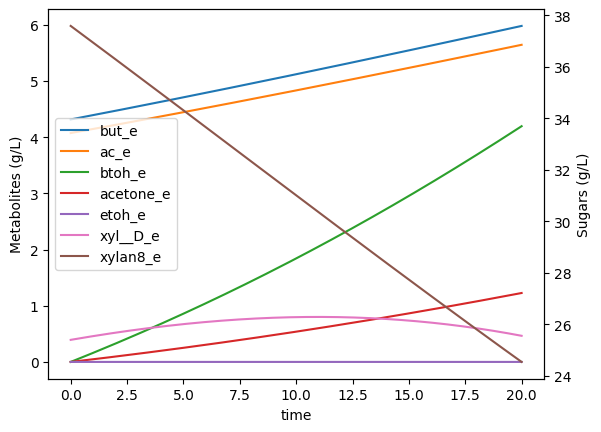

In [27]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "xylan8_e", "but_e", "ac_e", "etoh_e", "btoh_e", "acetone_e"]

#metabolites = ["btoh_e"]

plot_metabolites(troubleshoot_sim, metabolites, time_step=0.01)

In [73]:
# find the biggest difference in metabolite concentration between the two simulations
diff = abs(both_med) - abs(just_m5_med)

In [74]:
diff.sort_values(ascending=False)

metabolite
co2_e        1.699182e+00
h2_e         1.283390e+00
btoh_e       5.402817e-01
xylan8_e     4.042905e-03
h2s_e        8.308000e-08
                 ...     
4hba_e                NaN
acetone_e             NaN
dhptd_e               NaN
etoh_e                NaN
ppap_e                NaN
Name: 510, Length: 76, dtype: float64

In [75]:
# get all nan values in diff
diff[diff.isna()]

metabolite
4hba_e      NaN
acetone_e   NaN
dhptd_e     NaN
etoh_e      NaN
ppap_e      NaN
Name: 510, dtype: float64

In [53]:
both_med["ppap_e"]

0.44693246205

In [22]:
both_med["co2_e"], just_m5_med["co2_e"]

(11.530735392, 9.8463326359)

In [23]:
both_med["h2_e"], just_m5_med["h2_e"]

(10.268429286, 8.9832713215)

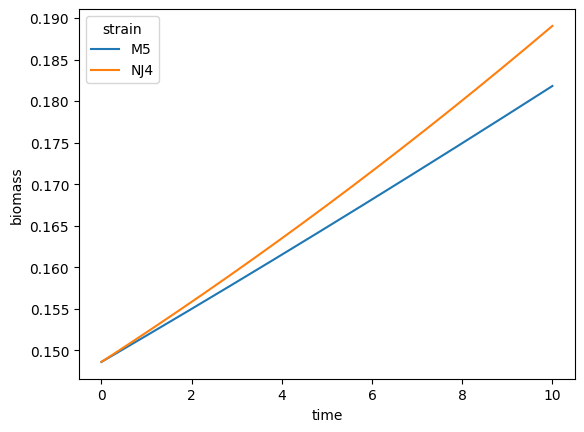

In [23]:
plot_biomass(troubleshoot_sim, time_step=0.01)

In [9]:
change_series = troubleshoot_sim.total_biomass["M5"].diff() <= 0
print("M5 stops growing at", change_series[change_series].index[0] * 0.01, "h, or cycle", change_series[change_series].index[0])

M5 stops growing at 7.11 h, or cycle 711


In [10]:
start_med = troubleshoot_sim.get_metabolite_time_series().iloc[711]
start_med[start_med < 1e-4]

metabolite
4hba_e      5.317924e-06
arg__L_e    6.061773e-59
asp__L_e    1.017480e-54
dcyt_e      2.749918e-50
dhptd_e     2.658962e-06
etoh_e      1.110325e-07
ile__L_e    5.823589e-11
ser__L_e    8.810684e-61
val__L_e    6.327446e-56
xylan4_e    2.931404e-50
Name: 711, dtype: float64

In [15]:
AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
                "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
                "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]

In [11]:
start_med = troubleshoot_sim.get_metabolite_time_series().iloc[205]
start_med[start_med < 1e-4]

metabolite
4hba_e      2.735252e-05
acald_e     0.000000e+00
arg__L_e    0.000000e+00
asp__L_e    0.000000e+00
dcyt_e      0.000000e+00
dhptd_e     1.367626e-05
etha_e      3.621382e-32
etoh_e      0.000000e+00
glu__L_e    0.000000e+00
ile__L_e    0.000000e+00
ser__L_e    0.000000e+00
thr__L_e    0.000000e+00
val__L_e    0.000000e+00
xylan4_e    0.000000e+00
Name: 205, dtype: float64

In [35]:
crit_med = troubleshoot_sim.get_metabolite_time_series().iloc[449]

In [36]:
crit_med[crit_med < 1e-4]

metabolite
4hba_e      5.203926e-06
acald_e     1.767695e-12
dcyt_e      3.200066e-06
dhptd_e     2.601963e-06
etha_e      0.000000e+00
lcts_e      1.902291e-20
ser__L_e    5.566818e-13
xylan4_e    6.245758e-52
Name: 449, dtype: float64

In [ ]:
["arg__L_e", "asp__L_e", "dcyt_e", "ser__L_e", "val__L_e"]

In [77]:
all_fluxes = troubleshoot_sim.fluxes_by_species["M5"]
# check which fluxes (either internal or external) are getting close to zero (abs(v) < 1e-4) between cycle 400 and 600
close_to_zero = all_fluxes.loc[500:503].apply(lambda x: (x.abs() < 1e-10).all(), axis=0)
# get a list of the fluxes which are close to zero
suspect_fluxes = close_to_zero[close_to_zero].index

series_405 = all_fluxes[suspect_fluxes].iloc[405]
series_505 = all_fluxes[suspect_fluxes].iloc[508]
# find the fluxes that have different values from cycle 405 and 505 
diff_fluxes = series_405[series_405 != series_505]

super_suspect_fluxes = diff_fluxes.index

super_suspect_fluxes

Index(['ALCD2x', 'IBTMr', 'OIVD2', 'PFOR', 'RNTR1c', 'RNTR2c', 'RNTR3c',
       'RNTR4c', 'EX_arg__L_e', 'EX_asp__L_e', 'EX_dcyt_e', 'EX_etoh_e',
       'EX_ser__L_e', 'EX_val__L_e', 'EX_xylan4_e', 'ETOHt'],
      dtype='object')

In [78]:
for rx in super_suspect_fluxes:
    print(rx)
    print(all_fluxes[rx].iloc[405])
    print(all_fluxes[rx].iloc[508])

ALCD2x
0.0
-0.0022139347041
IBTMr
0.0
-0.028386211135
OIVD2
0.0
0.028386211135
PFOR
0.0
0.00058584019929
RNTR1c
0.0
0.00014411649075
RNTR2c
0.0
0.0001488036089
RNTR3c
0.0
0.0001488036089
RNTR4c
0.0
0.00014411649075
EX_arg__L_e
-1.8425103617000002e-48
-1.6661677547000002e-51
EX_asp__L_e
-3.0926867381999996e-44
-2.7966925048999997e-47
EX_dcyt_e
-1.5261740412e-44
-4.9869563065e-46
EX_etoh_e
-0.0
0.0022139347041
EX_ser__L_e
-2.6780574194e-50
-2.4217464445999998e-53
EX_val__L_e
-1.9232630368e-45
-1.7391917693000002e-48
EX_xylan4_e
-1.6268970315e-44
-5.3160807302e-46
ETOHt
0.0
-0.0022139347041


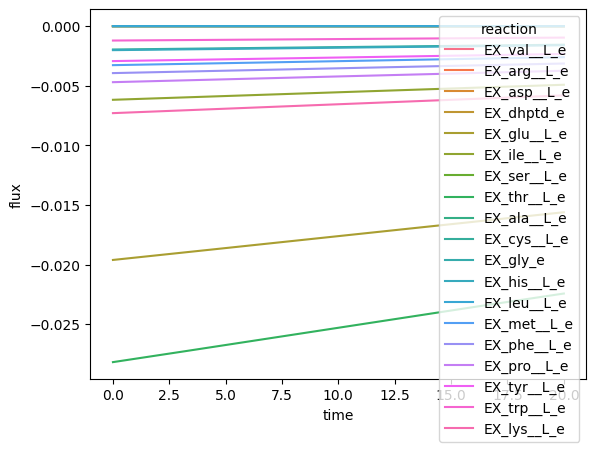

In [28]:
plot_reaction_flux(troubleshoot_sim, AA_uptake_rx, "M5", time_step=0.01)

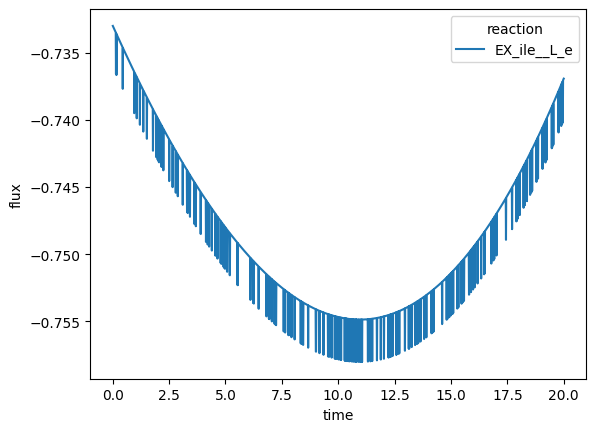

In [29]:
plot_reaction_flux(troubleshoot_sim, ["EX_ile__L_e"], "NJ4", time_step=0.01)

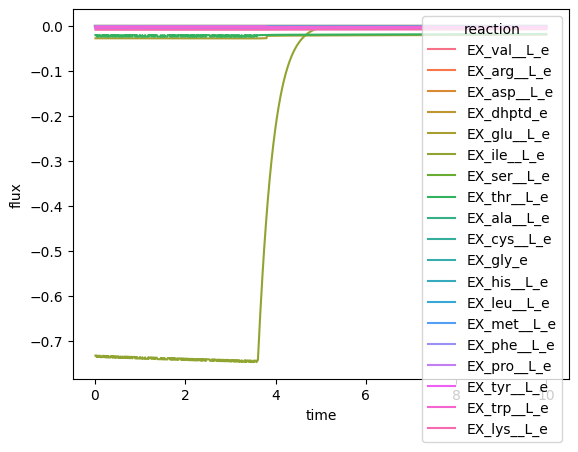

In [17]:
plot_reaction_flux(troubleshoot_sim, AA_uptake_rx, "NJ4", time_step=0.01)

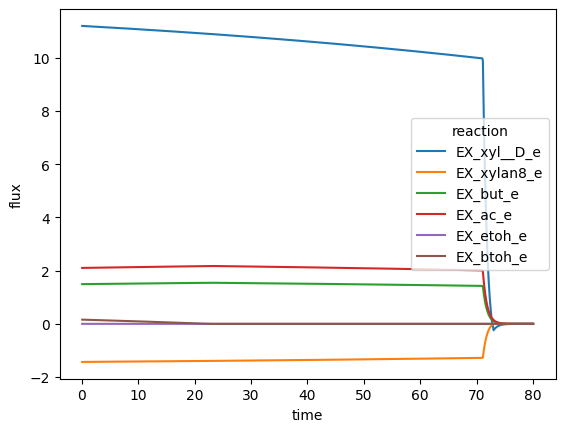

In [11]:
plot_reaction_flux(troubleshoot_sim, ["EX_xyl__D_e", "EX_xylan8_e", "EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"], "M5")

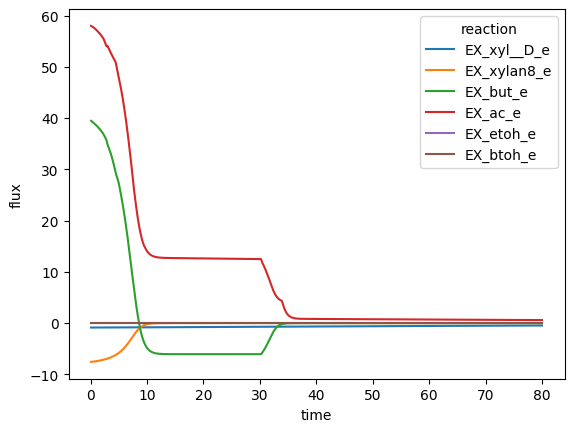

In [87]:
plot_reaction_flux(troubleshoot_sim, ["EX_xyl__D_e", "EX_xylan8_e", "EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"], "NJ4")

In [43]:
suspect_AA = ["EX_arg__L_e", "EX_asp__L_e", "EX_glu__L_e", "EX_ser__L_e", "EX_ile__L_e", "EX_thr__L_e", "EX_val__L_e"]

In [44]:
from utils import static_sim

test_med = {aa:0 for aa in suspect_AA}
test_med.update({"EX_xylan4_e": 0, "EX_xylan8_e": 1, "EX_nh4_e": 10, "EX_h_e": 5, "EX_h2o_e": 10})

medium = static_sim.get_specific_medium(m5, test_med)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [47]:
from cobra.flux_analysis import pfba

for aa in suspect_AA:
    medium[aa] = 0.1

    with m5:
        m5.medium = medium
        sol = m5.optimize()
        if sol.objective_value > 1e-4:
            print(aa, sol.objective_value)

    medium[aa] = 0

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the mos

EX_ile__L_e 0.008103222609734466


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [46]:
from utils import static_sim

test_med = {aa:0 for aa in suspect_AA}
test_med.update({"EX_xyl__D_e": 10, "EX_nh4_e": 10, "EX_h_e":10, "EX_but_e": 10, "EX_ac_e": 10})

medium = static_sim.get_specific_medium(nj4, test_med)

with nj4 as model:
        model.medium = medium
        sol = model.optimize()
        print(sol.objective_value)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


0.24482069251173935


In [39]:
sol.objective_value

0.0

### --------- end of troubleshoot ----------

In [38]:
bm, met, fluxes = cf.collapse_sequential_sim(first_sim, second_sim)

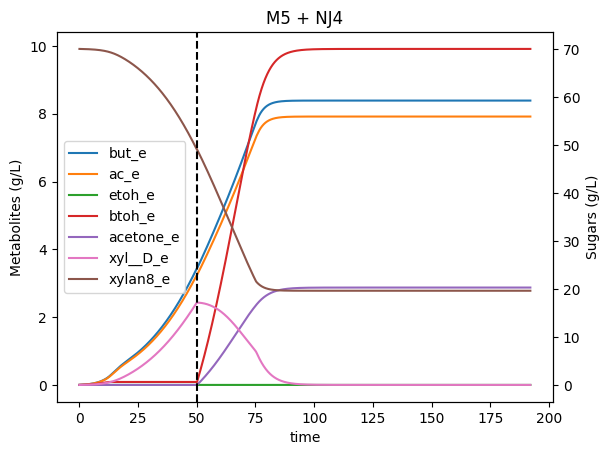

In [42]:
metabolites = ["but_e",  "ac_e", "etoh_e", "btoh_e", "acetone_e", "xyl__D_e", "xylan8_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME)

import matplotlib.pyplot as plt
# plt.title("M5 + NJ4")
# plt.savefig("figures/community.svg", format="svg")

In [32]:
# find the metablites from the medium which runs out at some point
suspects = [met for met in added_metabilotes.keys() if met in second_sim.get_metabolite_time_series().columns]
suspect_df = second_sim.get_metabolite_time_series()[suspects]
suspect_df.loc[:, suspect_df.iloc[-1] == 0]

metabolite,dcyt_e
0,5.981177e-24
1,4.351974e-24
2,3.161527e-24
3,2.293059e-24
4,1.660496e-24
...,...
1416,0.000000e+00
1417,0.000000e+00
1418,0.000000e+00
1419,0.000000e+00


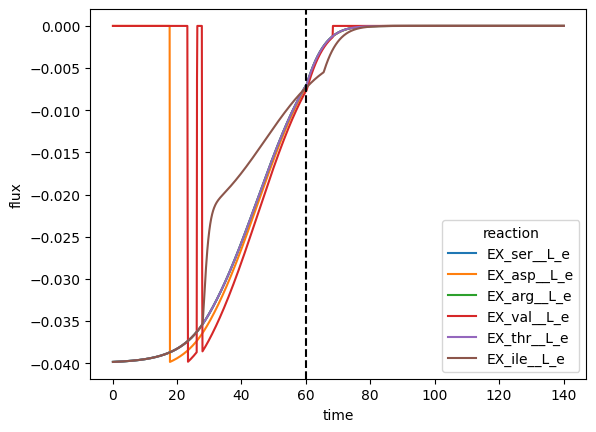

In [24]:
cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=["EX_" + aa for aa in amino_acids], inoc_time=INOC_TIME)

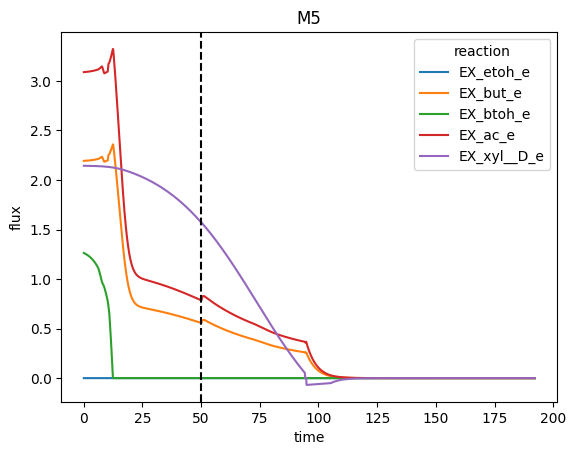

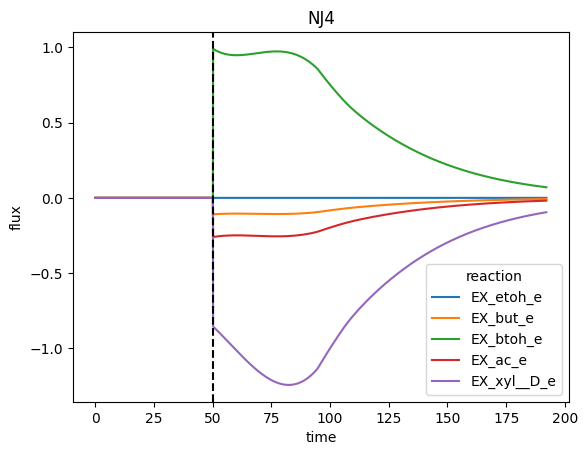

In [21]:
import matplotlib.pyplot as plt

production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('M5')
plt.show()

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('NJ4')
plt.show()

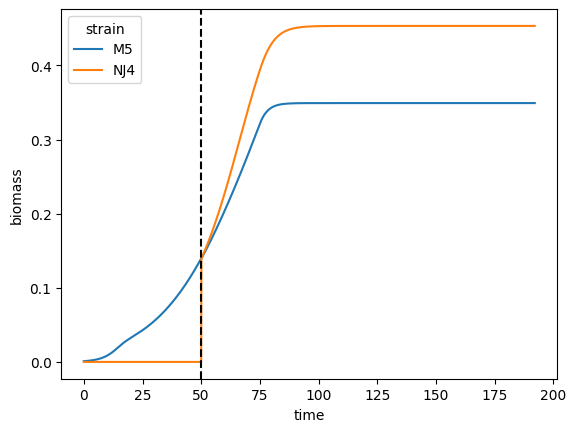

In [40]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)

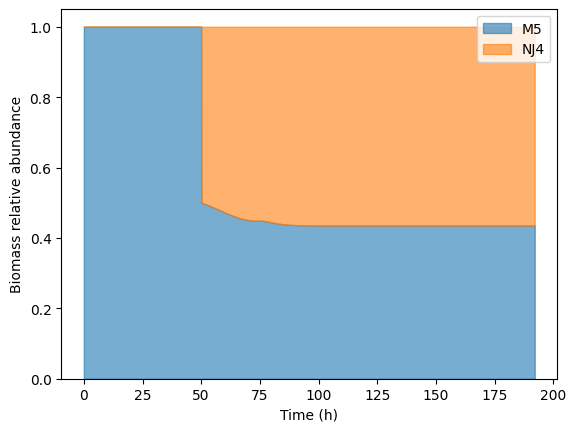

In [41]:
cf.plot_relative_abundance(total_biomass=bm)

## three-stage simulation w/ phase -switch

In [22]:
from cobra.io import read_sbml_model
from utils.flux_coupling import add_ratio_constraint_cobra

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

In [23]:
# M5

uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]

for rx in uptake_KO:
    m5.reactions.get_by_id(rx).bounds = (0, 0)

# restrict rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.4)

# restrict uptake of butanol
m5.reactions.BTOHt.bounds = (-1000, 0)

from utils.flux_coupling import add_ratio_constraint_cobra

# flux coupling constraint forcing but/ac production to exp. values
add_ratio_constraint_cobra(m5, "BUTt" , "ACtr",  0.71, r_num_reverse=False, r_den_reverse=False)

reactions = ["ACACT1r", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", 
            "PTAr", "POR_syn", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "ACKr", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f", #ABE pathway
                      ]

for rx in reactions:
    m5.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    m5.reactions.get_by_id(rx).bounds = (-1000, 0)


In [24]:
# nj4
# define the Specific Proton Flux (SPF) property

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

# as an objective
SPF_obj = nj4.problem.Objective(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

nj4_acido = nj4.copy()
nj4_solvento = nj4.copy()

# restrict reaction reversibility

reactions = ["ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", 
             "ADCi", "PTAr", "POR_syn", "FNOR", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f", #ABE pathway
                      ]

KO_rx = ["XYLANabc", "GLCURS1"] #xylan uptake reactions

for rx in reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 1000)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (-1000, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (-1000, 0)

for rx in KO_rx:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 0)

# TCA cycle
nj4_acido.reactions.SUCD2.bounds = (-1000, 1000)

# "closing off" reductive TCA for solventogenesis
nj4_solvento.reactions.SUCD2.bounds = (-1000, 0)
nj4_solvento.reactions.MDH.bounds = (-1000, 0)
# nj4_solvento.reactions.FUM.bounds = (-1000, 0)

# knock out reactions for acetate and butyrate production
nj4_solvento.reactions.ACtr.bounds = (0, 1000)
nj4_solvento.reactions.BUTt.bounds = (0, 1000)

from utils.flux_coupling import add_ratio_constraint_cobra

# flux coupling but/ac production for acidogeneis to exp. value
add_ratio_constraint_cobra(nj4_acido, "BUTt" , "ACtr",  1.02, r_num_reverse=True, r_den_reverse=True)

# flux coupling btoh/acetone production for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4_solvento, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

# add SPF objectove to solventogen model
nj4_solvento.objective = SPF_obj

In [25]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

VOLUME = 0.05
MM_XYLAN8 = 1201.04
xylan_concentration = 70 #g/L

added_metabilotes["xylan8_e"] = (xylan_concentration * VOLUME / MM_XYLAN8) * 1000
added_metabilotes["xylan4_e"] = 0

In [26]:
from utils.kinetic_params import KINETIC_PARAMS

In [27]:
# updated the kinetic params file - this should no longer be necessary
# AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
#                 "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
#                 "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]

# for strain in KINETIC_PARAMS.keys():
#     for rx in AA_uptake_rx:
#         KINETIC_PARAMS[strain]["km"][rx] = 1

In [28]:
# using exact same parameters as in the individual sims

# restrict rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.35)#0.8)

# nj4 kinetic params
# all default / from param list

# KINETIC_PARAMS["NJ4"]["km"]["EX_xyl__D_e"] = 1
# KINETIC_PARAMS["NJ4"]["vmax"]["EX_xyl__D_e"] = 6

#m5 kinetic params
KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 0.9 #1
KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 10

KINETIC_PARAMS["M5"]["km"]["EX_xyl__D_e"] = 10
KINETIC_PARAMS["M5"]["vmax"]["EX_xyl__D_e"] = 2

In [29]:
m5_cold = m5.copy()
#m5_cold.reactions.ATPM.bounds = (0.1, 1000)

#m5_cold.reactions.XYLt2.bounds = (0, 0.2)

In [30]:
INOC_TIME = 50

In [31]:
from copy import deepcopy

kinetic_params_cold = deepcopy(KINETIC_PARAMS)
kinetic_params_cold["M5"]["km"]["EX_xylan8_e"] = 1.5 # 1.5
kinetic_params_cold["M5"]["vmax"]["EX_xylan8_e"] = 8

In [11]:
from utils import comets_functions as cf

first_sim, second_sim, third_sim = cf.sequential_with_switch(m5=m5, nj4_acido=nj4_acido, nj4_solvento=nj4_solvento, m5_cold=m5_cold, init_medium=added_metabilotes, 
                                                             kinetic_params=KINETIC_PARAMS, inoc_time=INOC_TIME, initial_pop_m5=0.0005, kinetic_params_cold=kinetic_params_cold)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [12]:
bm, met, fluxes = cf.collapse_three_sim(first_sim, second_sim, third_sim)

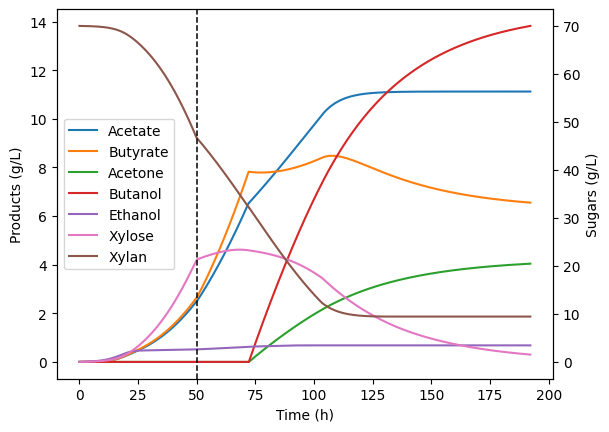

In [14]:
metabolites = ["xyl__D_e", "xylan8_e", "ac_e", "but_e",  "acetone_e", "btoh_e",  "etoh_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME, use_molar_amount=False, common_names=True)

import matplotlib.pyplot as plt
plt.savefig("figures/community.svg", format="svg")

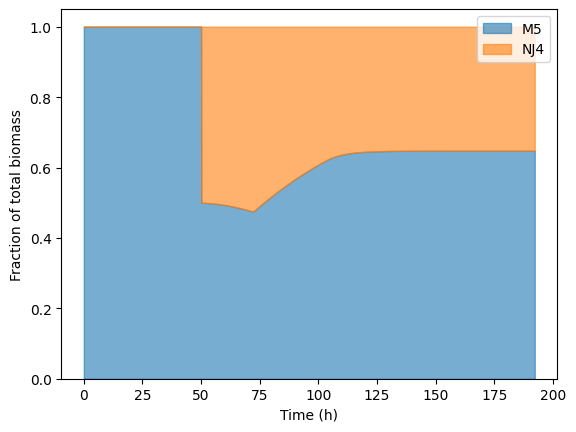

In [15]:
cf.plot_relative_abundance(total_biomass=bm)

# import matplotlib.pyplot as plt
plt.savefig("figures/community_ra.svg", format="svg")

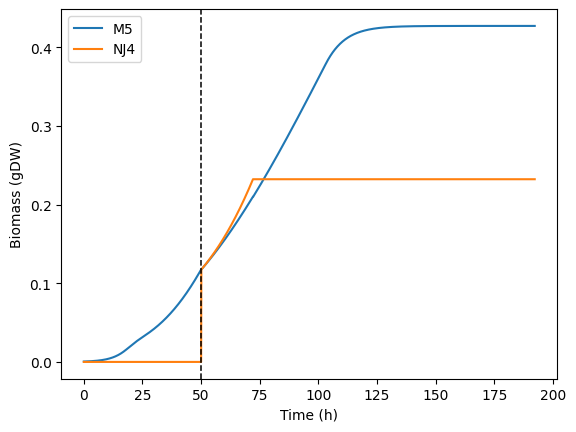

In [16]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)
plt.savefig("figures/community_bm.svg", format="svg")

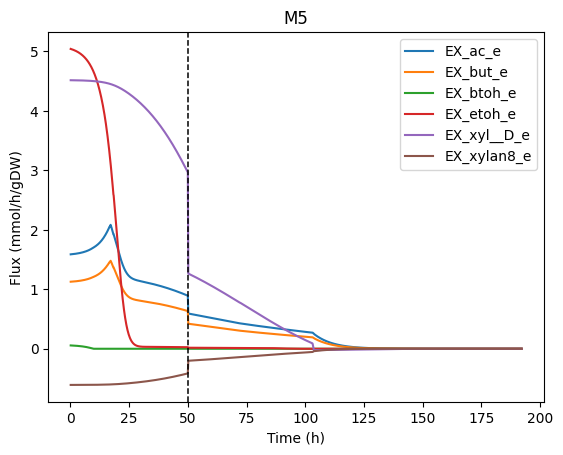

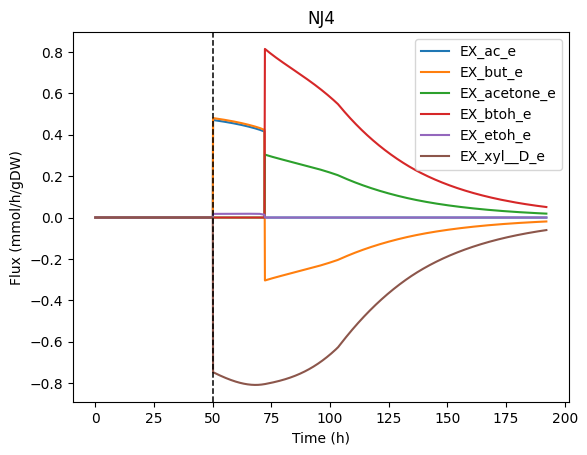

In [21]:
import matplotlib.pyplot as plt

production_reactions = ["EX_ac_e", "EX_but_e", "EX_btoh_e", "EX_etoh_e", "EX_xyl__D_e", "EX_xylan8_e"]


cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.savefig("figures/community_flux_M5.svg", format="svg")
plt.title('M5')
plt.show()

production_reactions = ["EX_ac_e", "EX_but_e", "EX_acetone_e", "EX_btoh_e", "EX_etoh_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.savefig("figures/community_flux_NJ4.svg", format="svg")
plt.title('NJ4')
plt.show()

### with automatic switch

In [32]:
from utils import comets_functions as cf

first_sim, second_sim, third_sim = cf.sequential_with_switch(m5=m5, nj4_acido=nj4_acido, nj4_solvento=nj4_solvento, m5_cold=m5_cold, init_medium=added_metabilotes, 
                                                  kinetic_params=KINETIC_PARAMS, inoc_time=INOC_TIME, find_switch_time=True, kinetic_params_cold=kinetic_params_cold)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [33]:
bm, met, fluxes = cf.collapse_three_sim(first_sim, second_sim, third_sim)

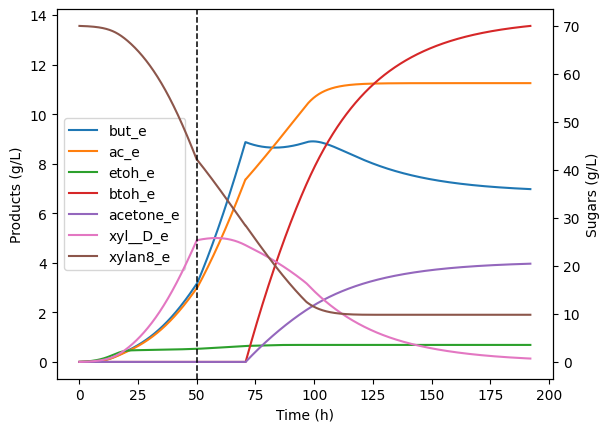

In [34]:
metabolites = ["but_e",  "ac_e", "etoh_e", "btoh_e", "acetone_e", "xyl__D_e", "xylan8_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME, use_molar_amount=False)

## Fermentation parameter optimisation

In [4]:
import pandas as pd

df1 = pd.read_csv("grid_search_results/grid_search_result_Mar_14_2313.csv")
df2 = pd.read_csv("grid_search_results/grid_search_result_Mar_15_0918.csv")

In [5]:
df = pd.concat([df1, df2])

In [6]:
from utils import unit_conversion

df["Butanol (g/L)"] = unit_conversion.mmol_to_g_per_L("btoh_e", df["butanol"])

In [ ]:
# grid1
inoculation_times = [24, 48, 72]
inoculation_ratios = [0.5, 1, 1.33]
xylan_concentrations = [40, 60, 80]

# grid2
inoculation_times = [40, 50, 60]
inoculation_ratios = [0.75, 1, 1.25]
xylan_concentrations = [60, 70, 80]

# find the missing combinations?

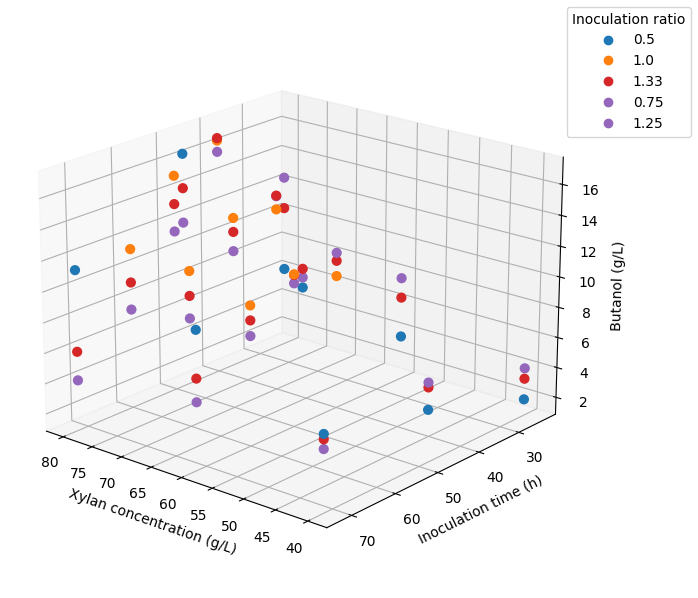

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap

x = df["xylan_conc"]
y = df["inoc_time"]
c = df["inoc_ratio"]
z = df["Butanol (g/L)"]

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette(n_colors=len(c.unique())).as_hex())

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with 'inoc_ratio' as color
sc = ax.scatter(x, y, z, c=c, s=40, alpha = 1, cmap=cmap)

ax.set_xlabel('Xylan concentration (g/L)')
ax.set_ylabel('Inoculation time (h)')
ax.set_zlabel('Butanol (g/L)')

fig.legend(handles=sc.legend_elements()[0], labels=list(c.unique()), title="Inoculation ratio", loc="upper right")

sc._axes.view_init(elev=20, azim=130)

plt.tight_layout()

plt.savefig("figures/ferm_opt_3d.svg", format="svg")

In [57]:
df.head()

,inoc_time,inoc_ratio,xylan_conc,butanol,Butanol (g/L)
0,24,0.5,40,1.304359,1.933581
1,24,0.5,60,2.527132,3.746221
2,24,0.5,80,4.123087,6.112064
3,24,1.0,40,2.239827,3.320320
4,24,1.0,60,4.320377,6.404527


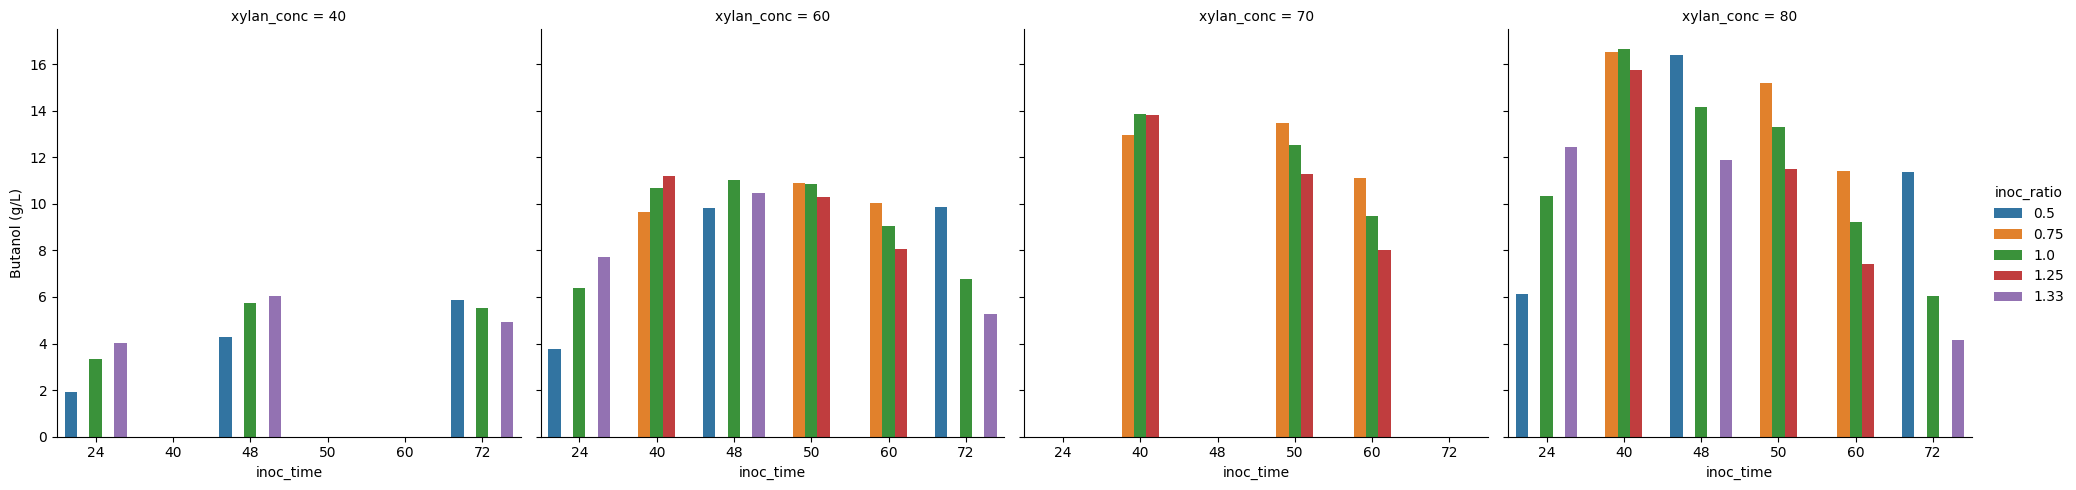

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x="inoc_time" , hue="inoc_ratio" , col='xylan_conc', y="Butanol (g/L)", kind="bar", data=df)

#plt.savefig("figures/ferm_opt.svg", format="svg")

In [49]:
import statsmodels.api as sm

# Create dummy variables for categorical variables
df_with_dummies = pd.get_dummies(df.drop(columns="butanol"), columns=['inoc_time', 'inoc_ratio', 'xylan_conc'], drop_first=True)

# Add intercept term
df_with_dummies = sm.add_constant(df_with_dummies)

# Perform linear regression
model = sm.OLS(df['Butanol (g/L)'], df_with_dummies)
results = model.fit()

# Print summary statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Butanol (g/L)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.456e+30
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:15:07   Log-Likelihood:                 1721.1
No. Observations:                  54   AIC:                            -3414.
Df Residuals:                      40   BIC:                            -3386.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.664e-15   2.31e-15     